<a href="https://colab.research.google.com/github/fernandofsilva/Keras/blob/main/Validation%2C_regularisation_and_callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


# Validation, regularisation and callbacks

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()

In [3]:
# Save the input and target variables
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [4]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0) / targets.std())

In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=.1)

#### Train a feedforward neural network model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    # Build the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    return model

model = get_model()

In [9]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [10]:
# Compile the model
model.compile(optimizer='Adam', loss='mse', metrics=['mae'])

In [11]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [12]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 2900.3596 - mae: 45.0829


[2900.359619140625, 45.082908630371094]

#### Plot the learning curves

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

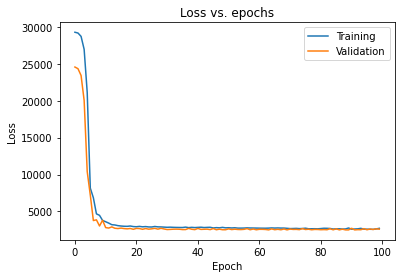

In [14]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [15]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [16]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd), input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [17]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-3, 0.3)

In [18]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [19]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [20]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 2933.6167 - mae: 45.1012


[2933.61669921875, 45.10117721557617]

#### Plot the learning curves

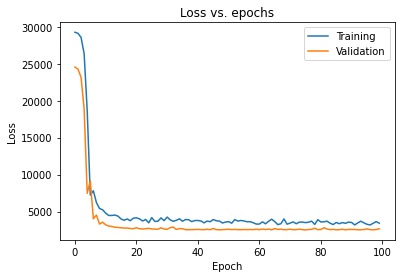

In [21]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [33]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainningCallback(Callback):
    
    def on_train_begin(self, logs=None):
        print('Starting Train')
    
    def on_epoch_begin(self, epoch, logs=None):
        print(f'Starting epoch {epoch}')
        
    def on_train_batch_begin(self, batch, logs=None):
        print(f'Traning: Starting batch {batch}')
    
    def on_train_batch_end(self, batch, logs=None):
        print(f'Traning: Finishing batch {batch}')

    def on_epoch_end(self, epoch, logs=None):
        print(f'Finishing epoch {epoch}')

    def on_train_end(self, logs=None):
        print('Finishing Train')

class TestingCallback(Callback):
    
    def on_test_begin(self, logs=None):
        print('Starting Test')
       
    def on_test_batch_begin(self, batch, logs=None):
        print(f'Testing: Starting batch {batch}')
    
    def on_test_batch_end(self, batch, logs=None):
        print(f'Testing: Finishing batch {batch}')

    def on_test_end(self, logs=None):
        print('Finishing Test')

class PredictionCallback(Callback):
    
    def on_predict_begin(self, logs=None):
        print('Starting prediction')
       
    def on_predict_batch_begin(self, batch, logs=None):
        print(f'Prediction: Starting batch {batch}')
    
    def on_predict_batch_end(self, batch, logs=None):
        print(f'Prediction: Finishing batch {batch}')

    def on_predict_end(self, logs=None):
        print('Finishing Prediction')


In [34]:
# Re-build the model
model = get_regularised_model(1e-3, 0.3)

In [35]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

#### Train the model with the callback

In [36]:
# Train the model, with some of the data reserved for validation
model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False, callbacks=[TrainningCallback()])

Starting Train
Starting epoch 0
Traning: Starting batch 0
Traning: Finishing batch 0
Traning: Starting batch 1
Traning: Finishing batch 1
Traning: Starting batch 2
Traning: Finishing batch 2
Traning: Starting batch 3
Traning: Finishing batch 3
Traning: Starting batch 4
Traning: Finishing batch 4
Traning: Starting batch 5
Traning: Finishing batch 5
Finishing epoch 0
Starting epoch 1
Traning: Starting batch 0
Traning: Finishing batch 0
Traning: Starting batch 1
Traning: Finishing batch 1
Traning: Starting batch 2
Traning: Finishing batch 2
Traning: Starting batch 3
Traning: Finishing batch 3
Traning: Starting batch 4
Traning: Finishing batch 4
Traning: Starting batch 5
Traning: Finishing batch 5
Finishing epoch 1
Starting epoch 2
Traning: Starting batch 0
Traning: Finishing batch 0
Traning: Starting batch 1
Traning: Finishing batch 1
Traning: Starting batch 2
Traning: Finishing batch 2
Traning: Starting batch 3
Traning: Finishing batch 3
Traning: Starting batch 4
Traning: Finishing batch

In [39]:
# Evaluate the model
model.evaluate(test_data, test_targets, verbose=False, callbacks=[TestingCallback()])

Starting Test
Testing: Starting batch 0
Testing: Finishing batch 0
Testing: Starting batch 1
Testing: Finishing batch 1
Finishing Test


2691.51416015625

In [41]:
# Make predictions with the model
model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])

Starting prediction
Prediction: Starting batch 0
Prediction: Finishing batch 0
Prediction: Starting batch 1
Prediction: Finishing batch 1
Finishing Prediction


array([[ 70.795296],
       [ 71.487114],
       [217.52457 ],
       [162.357   ],
       [142.41183 ],
       [113.7286  ],
       [100.061134],
       [161.11102 ],
       [277.6532  ],
       [ 75.30668 ],
       [135.55997 ],
       [134.70325 ],
       [112.02981 ],
       [184.96068 ],
       [ 79.597664],
       [107.565636],
       [ 97.82888 ],
       [121.40058 ],
       [161.6806  ],
       [253.44487 ],
       [ 78.32775 ],
       [177.232   ],
       [106.023384],
       [ 78.22024 ],
       [215.21729 ],
       [178.91829 ],
       [222.11684 ],
       [ 76.63067 ],
       [ 73.89992 ],
       [131.87439 ],
       [240.67203 ],
       [178.0662  ],
       [173.08334 ],
       [101.86286 ],
       [ 81.92234 ],
       [232.55481 ],
       [139.54321 ],
       [109.47299 ],
       [148.22272 ],
       [132.10594 ],
       [148.94922 ],
       [167.62524 ],
       [165.47733 ],
       [ 74.35842 ],
       [167.8238  ]], dtype=float32)

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [46]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mse')
unregularised_model_history = unregularised_model.fit(
    train_data, train_targets, 
    epochs=100,
    validation_split=0.15,
    batch_size=64,
    verbose=False,
    callbacks=[tf.keras.callbacks.EarlyStopping()]
)

In [47]:
# Evaluate the model on the test set
unregularised_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 3848.0813


3848.081298828125

In [48]:
# Re-train the regularised model
# Re-train the unregularised model
regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer='adam', loss='mse')
regularised_model_history = regularised_model.fit(
    train_data,
    train_targets,
    epochs=100,
    validation_split=0.15,
    batch_size=64,
    verbose=False,
    callbacks=[tf.keras.callbacks.EarlyStopping()]
)

In [49]:
# Evaluate the model on the test set
regularised_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 5129.4707


5129.470703125

#### Plot the learning curves

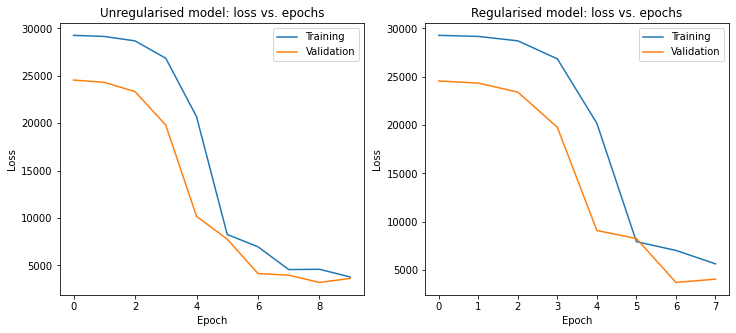

In [50]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)

plt.plot(unregularised_model_history.history['loss'])
plt.plot(unregularised_model_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(regularised_model_history.history['loss'])
plt.plot(regularised_model_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()